# X-ray image classification
> Balanced data

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
base_dir = 'chest_xray/reduced size - unbalanced/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

train_NORMAL_dir = os.path.join(train_dir, 'NORMAL')
train_PNEUMONIA_dir = os.path.join(train_dir, 'PNEUMONIA')

validation_NORMAL_dir = os.path.join(validation_dir, 'NORMAL')
validation_PNEUMONIA_dir = os.path.join(validation_dir, 'PNEUMONIA')

train_NORMAL_fnames = os.listdir( train_NORMAL_dir )
train_PNEUMONIA_fnames = os.listdir( train_PNEUMONIA_dir )

print(train_NORMAL_fnames[:10])
print(train_PNEUMONIA_fnames[:10])

print('total training NORMAL images :', len(os.listdir(      train_NORMAL_dir ) ))
print('total training PNEUMONIA images :', len(os.listdir(      train_PNEUMONIA_dir ) ))

print('total validation NORMAL images :', len(os.listdir( validation_NORMAL_dir ) ))
print('total validation PNEUMONIA images :', len(os.listdir( validation_PNEUMONIA_dir ) ))

['IM-0115-0001.jpeg', 'IM-0117-0001.jpeg', 'IM-0119-0001.jpeg', 'IM-0122-0001.jpeg', 'IM-0125-0001.jpeg', 'IM-0127-0001.jpeg', 'IM-0128-0001.jpeg', 'IM-0129-0001.jpeg', 'IM-0131-0001.jpeg', 'IM-0133-0001.jpeg']
['person100_virus_184.jpeg', 'person101_virus_187.jpeg', 'person101_virus_188.jpeg', 'person102_virus_189.jpeg', 'person103_virus_190.jpeg', 'person104_virus_191.jpeg', 'person105_virus_192.jpeg', 'person105_virus_193.jpeg', 'person106_virus_194.jpeg', 'person107_virus_197.jpeg']
total training NORMAL images : 500
total training PNEUMONIA images : 500
total validation NORMAL images : 100
total validation PNEUMONIA images : 100


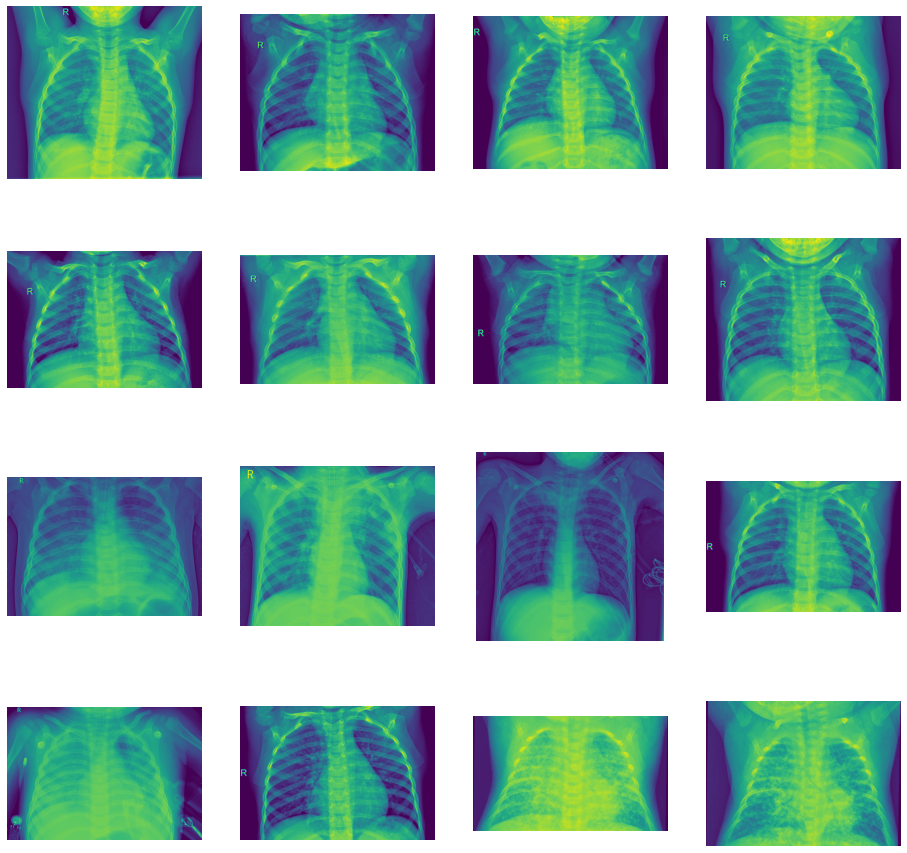

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4
pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_NORMAL_pix = [os.path.join(train_NORMAL_dir, fname)
                for fname in train_NORMAL_fnames[ pic_index-8:pic_index]
               ]

next_PNEUMONIA_pix = [os.path.join(train_PNEUMONIA_dir, fname)
                for fname in train_PNEUMONIA_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_NORMAL_pix+next_PNEUMONIA_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

In [4]:
class Conv(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(Conv, self).__init__()
        
        self.conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
        
    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = self.relu(x)
        x = self.pool(x)
        return x
    
model = tf.keras.Sequential(name='X-ray_CNN')

model.add(Conv(filters=32, kernel_size=(3, 3)))
model.add(Conv(filters=64, kernel_size=(3, 3)))
model.add(Conv(filters=128, kernel_size=(3, 3)))
model.add(Conv(filters=128, kernel_size=(3, 3)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=512, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

from glob import glob

base_dir = 'chest_xray/reduced size - unbalanced/'
train_len = len(glob(os.path.join(base_dir, 'train', 'NORMAL', '*.jpeg'))) * 2
val_len = len(glob(os.path.join(base_dir, 'val', 'NORMAL', '*.jpeg'))) * 2
test_len = len(glob(os.path.join(base_dir, 'test', 'NORMAL', '*.jpeg'))) * 2
train_len

1000

In [5]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator( rescale = 1.0/255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest'
                                    )
validation_datagen  = ImageDataGenerator( rescale = 1.0/255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest'
                                    )

In [6]:
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights

callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True,
                                                 save_weights_only=False,
                                                 verbose=1)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [7]:
import numpy as np

def load(f, label):
    # load the file into tensor
    image = tf.io.read_file(f)
    # Decode it to JPEG format
    image = tf.image.decode_jpeg(image)
    # Convert it to tf.float32
    image = tf.cast(image, tf.float32)
    
    return image, label

def resize(input_image, size):
    return tf.image.resize(input_image, size)

def random_crop(input_image):
    return tf.image.random_crop(input_image, size=[150, 150, 1])

def central_crop(input_image):
    image = resize(input_image, [176, 176])
    return tf.image.central_crop(image, central_fraction=0.84)

def random_rotation(input_image):
    angles = np.random.randint(0, 3, 1)
    return tf.image.rot90(input_image, k=angles[0])

def random_jitter(input_image):
    # Resize it to 176 x 176 x 3
    image = resize(input_image, [176, 176])
    # Randomly Crop to 150 x 150 x 3
    image = random_crop(image)
    # Randomly rotation
    image = random_rotation(image)
    # Randomly mirroring
    image = tf.image.random_flip_left_right(image)
    return image

def normalize(input_image):
    mid = (tf.reduce_max(input_image) + tf.reduce_min(input_image)) / 2
    input_image = input_image / mid - 1
    return input_image

def load_image_train(image_file, label):
    image, label = load(image_file, label)
    image = random_jitter(image)
    image = normalize(image)
    return image, label

def load_image_val(image_file, label):
    image, label = load(image_file, label)
    image = central_crop(image)
    image = normalize(image)
    return image, label

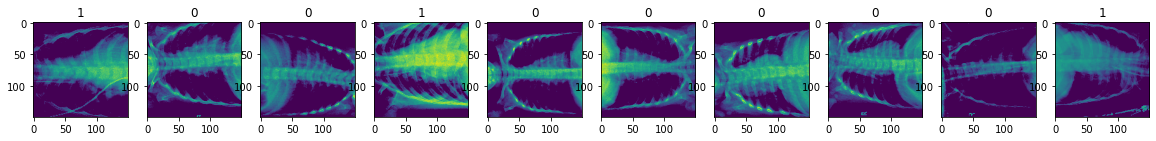

In [69]:
temp_ds = tf.data.Dataset.list_files(os.path.join("chest_xray/reduced size - unbalanced", 'train', 'NORMAL', '*.jpeg'))
temp_ds = temp_ds.map(lambda x: (x, 0))

temp2_ds = tf.data.Dataset.list_files(os.path.join("chest_xray/reduced size - unbalanced", 'train', 'PNEUMONIA', '*.jpeg'))
temp2_ds = temp2_ds.map(lambda x: (x, 1))
train_ds = temp_ds.concatenate(temp2_ds)

buffer_size = tf.data.experimental.cardinality(train_ds).numpy()
train_ds = train_ds.shuffle(buffer_size)\
                   .map(load_image_train, num_parallel_calls=16)\
                   .batch(20)\
                   .repeat()

temp_ds = tf.data.Dataset.list_files(os.path.join("chest_xray/reduced size - unbalanced", 'val', 'NORMAL', '*.jpeg'))
temp_ds = temp_ds.map(lambda x: (x, 0))

temp2_ds = tf.data.Dataset.list_files(os.path.join("chest_xray/reduced size - unbalanced", 'val', 'PNEUMONIA', '*.jpeg'))
temp2_ds = temp2_ds.map(lambda x: (x, 1))

val_ds = temp_ds.concatenate(temp2_ds)

val_ds = val_ds.map(load_image_val, num_parallel_calls=16)\
               .batch(20)\
               .repeat()

temp_ds = tf.data.Dataset.list_files(os.path.join("chest_xray/reduced size - unbalanced", 'test', 'NORMAL', '*.jpeg'))
temp_ds = temp_ds.map(lambda x: (x, 0))

temp2_ds = tf.data.Dataset.list_files(os.path.join("chest_xray/reduced size - unbalanced", 'test', 'PNEUMONIA', '*.jpeg'))
temp2_ds = temp2_ds.map(lambda x: (x, 1))

test_ds = temp_ds.concatenate(temp2_ds)

batch_size = 10
test_ds = test_ds.map(load_image_val, num_parallel_calls=16)\
               .batch(batch_size)\
               .repeat()

for images, labels in train_ds.take(1):
    fig, ax = plt.subplots(1, 10, figsize=(20, 6))
    for j in range(10):
        image = images[j].numpy()
        image = image / np.amax(image)
        image = np.clip(image, 0, 1)
        ax[j].imshow(image)
        ax[j].set_title(labels[j].numpy())
plt.show()

In [9]:
checkpoint_path = "./train/x-ray/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

In [10]:
base_dir = "chest_xray/reduced size - unbalanced/"
train_len = len(glob(os.path.join(base_dir, 'train', 'NORMAL', '*.jpeg'))) * 2
val_len = len(glob(os.path.join(base_dir, 'val', 'NORMAL', '*.jpeg'))) * 2
test_len = len(glob(os.path.join(base_dir, 'test', 'NORMAL', '*.jpeg'))) * 2
train_len

1000

In [11]:
history = model.fit(train_ds, 
          steps_per_epoch=train_len/20,
          validation_data=val_ds,
          validation_steps=val_len/20,
          epochs=50,
          verbose=1,
          callbacks=[cp_callback]
          )

Epoch 1/50
50/50 [==============================] - 45s 889ms/step - loss: 0.6228 - accuracy: 0.8100 - val_loss: 1.2893 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 1.28925, saving model to ./train/x-ray\cp-0001.ckpt
Epoch 2/50
50/50 [==============================] - 41s 828ms/step - loss: 0.1704 - accuracy: 0.9420 - val_loss: 2.0355 - val_accuracy: 0.5000

Epoch 00002: val_loss did not improve from 1.28925
Epoch 3/50
50/50 [==============================] - 43s 856ms/step - loss: 0.1305 - accuracy: 0.9530 - val_loss: 3.3920 - val_accuracy: 0.5000

Epoch 00003: val_loss did not improve from 1.28925
Epoch 4/50
50/50 [==============================] - 50s 995ms/step - loss: 0.1163 - accuracy: 0.9550 - val_loss: 3.7357 - val_accuracy: 0.5000

Epoch 00004: val_loss did not improve from 1.28925
Epoch 5/50
50/50 [==============================] - 51s 1s/step - loss: 0.1022 - accuracy: 0.9580 - val_loss: 3.5621 - val_accuracy: 0.5000

Epoch 00005: val_loss did not impro


Epoch 00042: val_loss did not improve from 1.19705
Epoch 43/50
50/50 [==============================] - 93s 2s/step - loss: 0.0557 - accuracy: 0.9820 - val_loss: 2.0978 - val_accuracy: 0.5600

Epoch 00043: val_loss did not improve from 1.19705
Epoch 44/50
50/50 [==============================] - 96s 2s/step - loss: 0.0361 - accuracy: 0.9870 - val_loss: 1.9620 - val_accuracy: 0.5650

Epoch 00044: val_loss did not improve from 1.19705
Epoch 45/50
50/50 [==============================] - 78s 2s/step - loss: 0.0486 - accuracy: 0.9860 - val_loss: 2.9720 - val_accuracy: 0.5100

Epoch 00045: val_loss did not improve from 1.19705
Epoch 46/50
50/50 [==============================] - 77s 2s/step - loss: 0.0289 - accuracy: 0.9880 - val_loss: 2.2873 - val_accuracy: 0.5700

Epoch 00046: val_loss did not improve from 1.19705
Epoch 47/50
50/50 [==============================] - 48s 930ms/step - loss: 0.0371 - accuracy: 0.9860 - val_loss: 4.2712 - val_accuracy: 0.5000

Epoch 00047: val_loss did not i

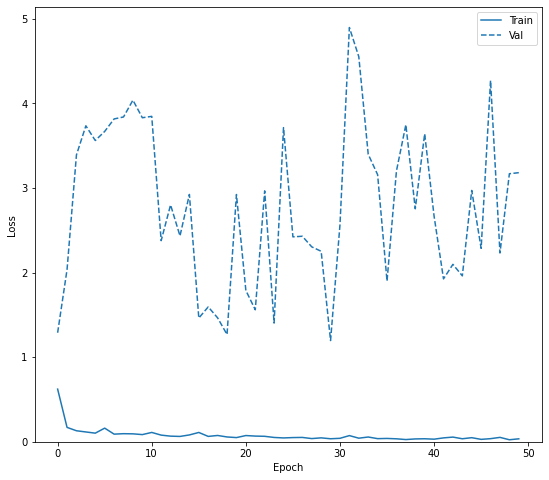

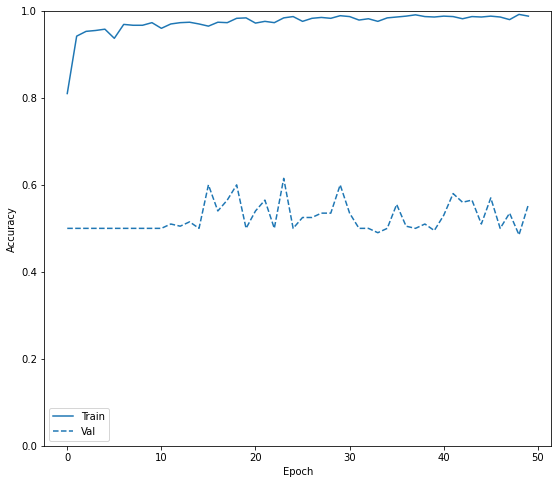

In [12]:
from matplotlib.pyplot import figure
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    figure(figsize=(20, 8))
    plt.subplot(1,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
plot_metrics(history)

In [13]:
model.summary()

Model: "X-ray_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv (Conv)                  (None, None, None, 32)    448       
_________________________________________________________________
conv_1 (Conv)                (None, None, None, 64)    18752     
_________________________________________________________________
conv_2 (Conv)                (None, None, None, 128)   74368     
_________________________________________________________________
conv_3 (Conv)                (None, None, None, 128)   148096    
_________________________________________________________________
flatten (Flatten)            (None, None)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3211776   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 10

In [121]:
test_ds

<RepeatDataset shapes: ((None, 148, 148, None), (None,)), types: (tf.float32, tf.int32)>

In [122]:
model.evaluate(test_ds, steps=int(test_len/batch_size))

20/20 [==============================] - 2s 116ms/step - loss: 1.7954 - accuracy: 0.6500


[1.795435905456543, 0.6499999761581421]

In [104]:
# """ Steps should be equal to total samples (including both of the folders inside test folder) 
# divided by batch size"""
# batch_size = 10
# predictions = model.predict(test_ds, steps=int(test_len/batch_size))
# predictions

# Need to convert the predictions to binaries to get classification report

In [105]:
# pred = [0]*predictions.shape[0]
# for i in range(predictions.shape[0]):
#     if float(predictions[i][0]) > float(predictions[i][1]):
#         pred[i] = 0
#     else:
#         pred[i] = 1
# pred

In [22]:
# predictions = model.predict(test_ds, steps=1)
# predictions

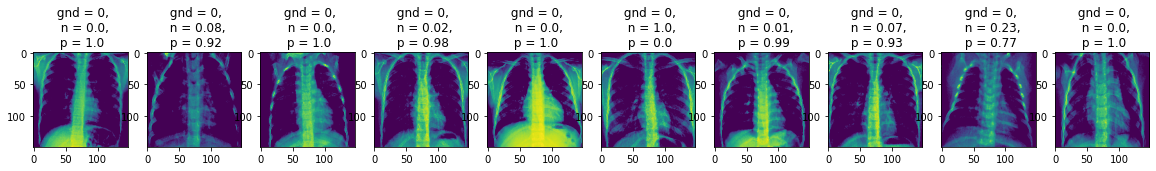

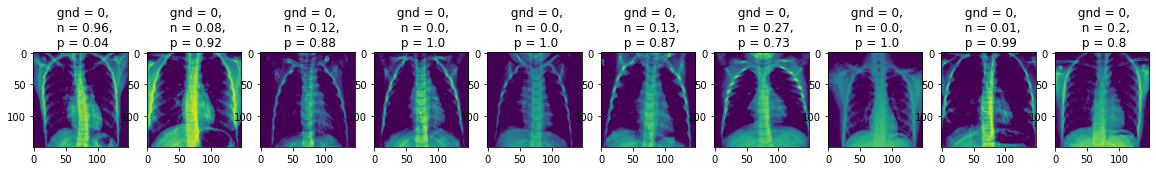

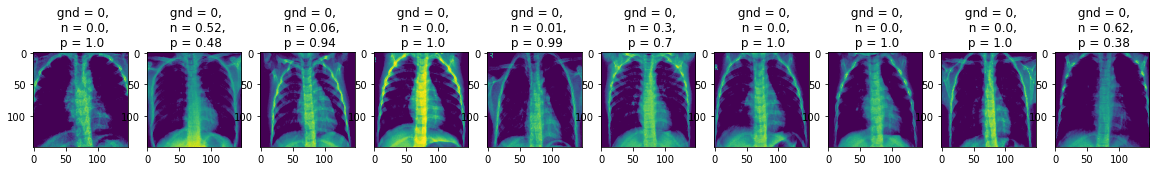

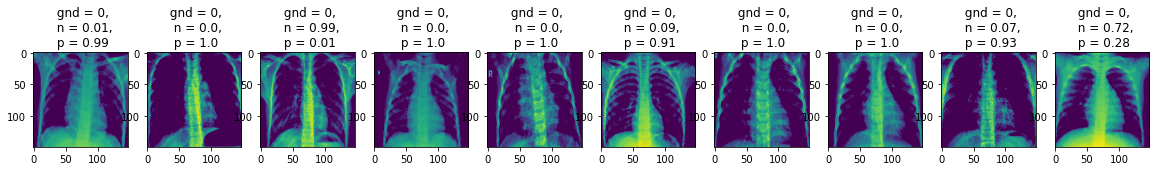

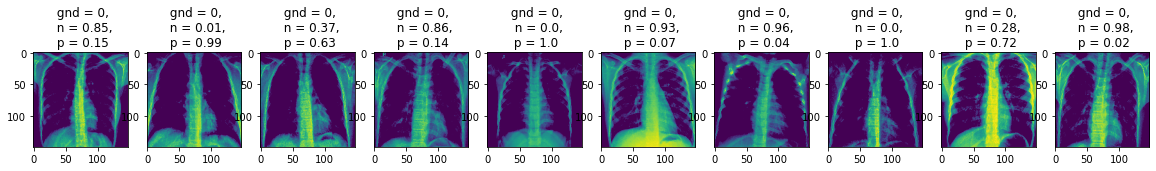

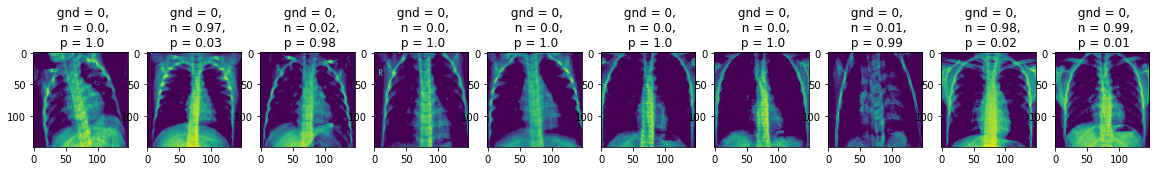

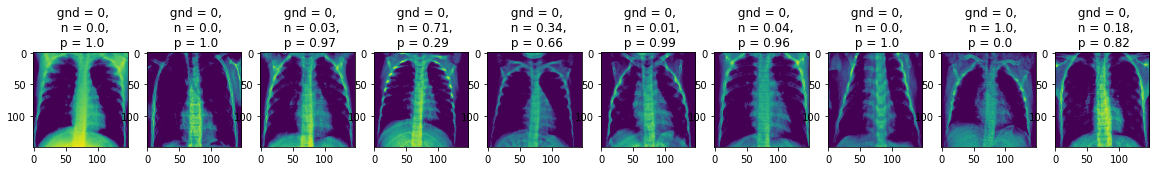

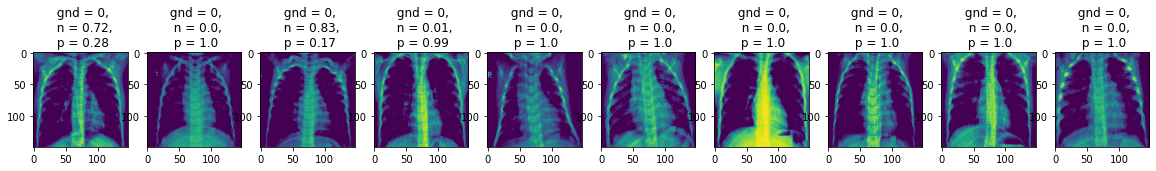

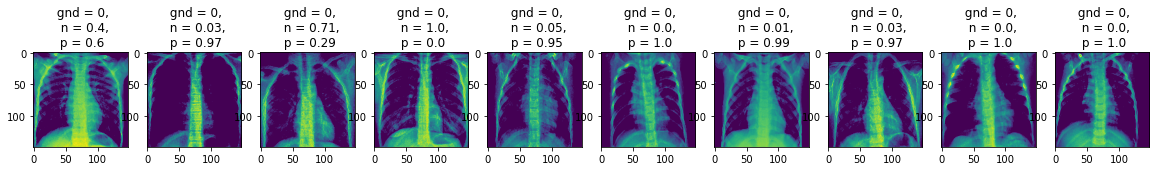

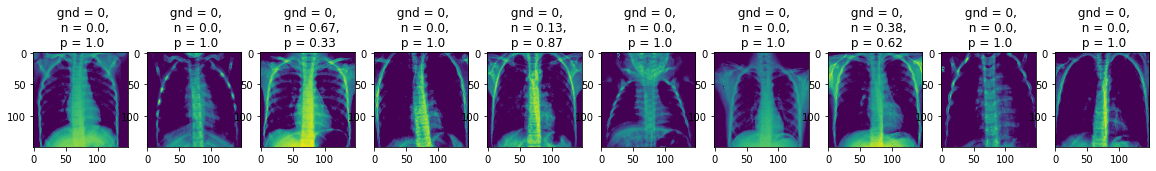

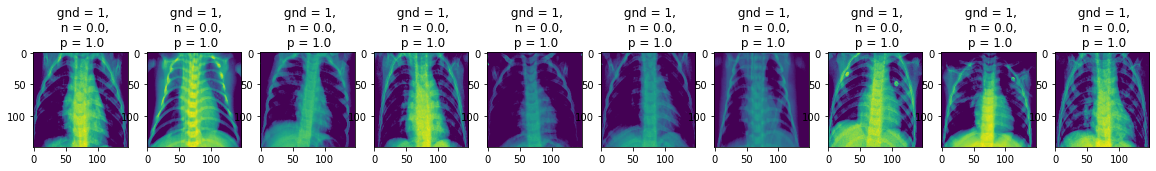

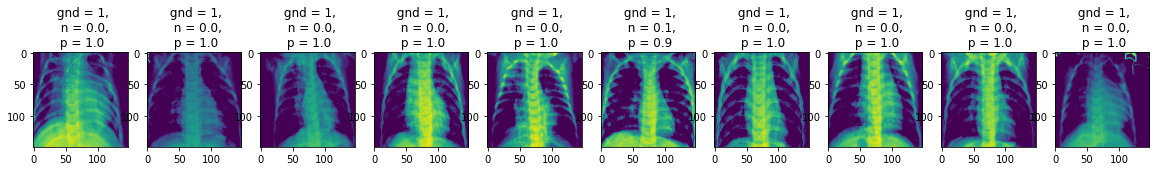

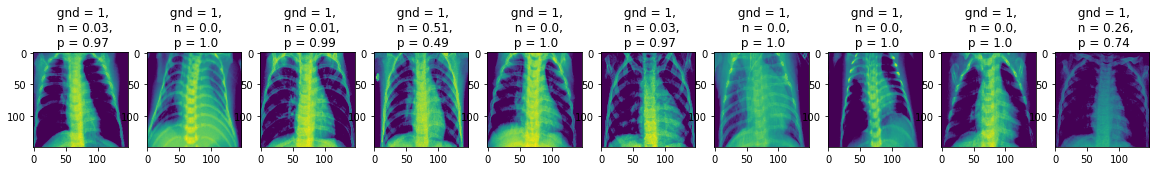

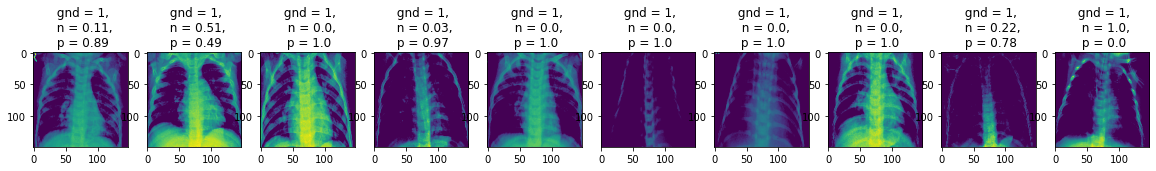

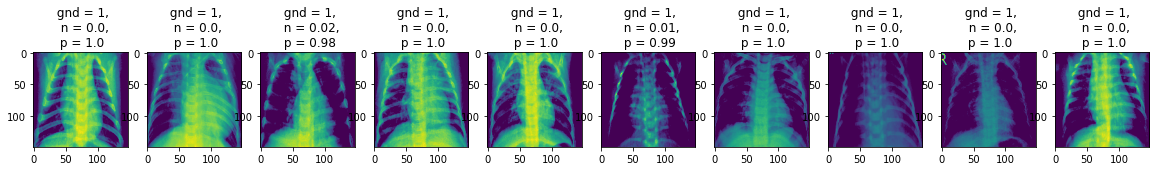

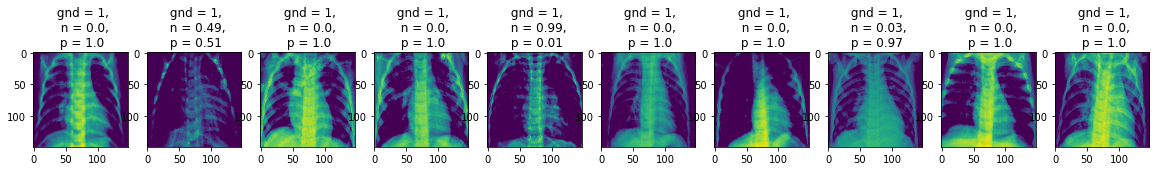

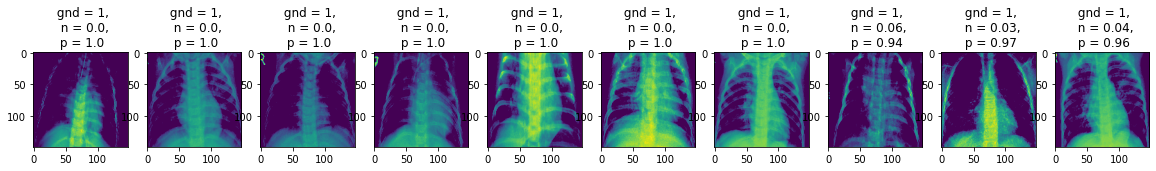

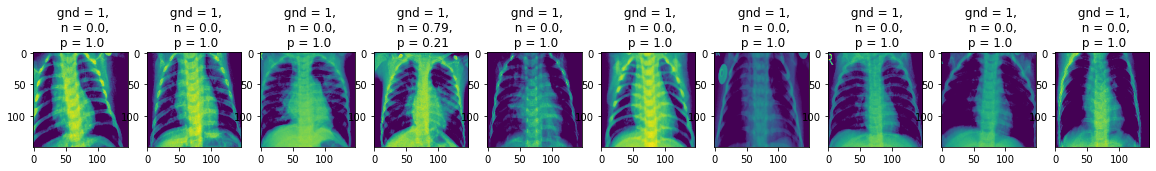

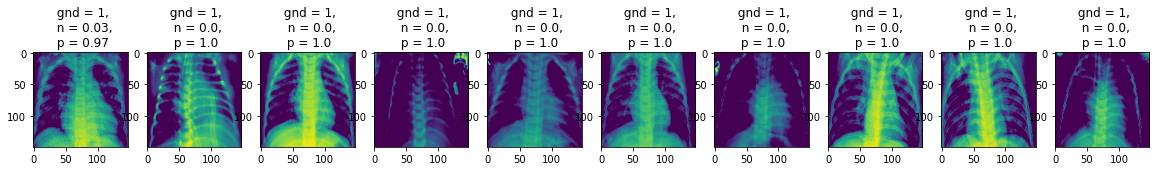

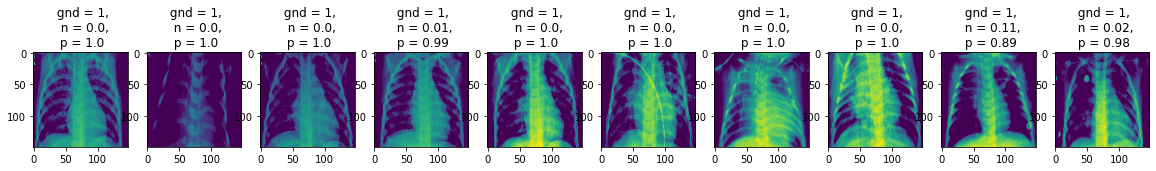

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[1.14945229e-03, 9.98850584e-01],
       [2.69589600e-06, 9.99997258e-01],
       [1.10955432e-03, 9.98890460e-01],
       [7.92705920e-03, 9.92072999e-01],
       [1.85973637e-04, 9.99814093e-01],
       [8.08138111e-07, 9.99999166e-01],
       [1.33695835e-06, 9.99998689e-01],
       [3.44434925e-10, 1.00000000e+00],
       [1.13873586e-01, 8.86126459e-01],
       [2.36099418e-02, 9.76390004e-01]], dtype=float32)>

In [123]:
i=0
p = []
gnd = []
prob = []

"""test_ds.take method takes samples from the test_ds n times when n is the number provided 
as argument. When all the samples are taken, it starts repeating from the first position"""

for images, labels in test_ds.take(int(test_len/batch_size)):
    i+=1
    predictions = model(images)
    p.append(predictions)
    fig, ax = plt.subplots(1, batch_size, figsize=(20, 6)) 
    """Here the second argument in plt.subplots is different from the test_ds.take method's argument
    plt.plot's second argument should be equalto the batch size whereas test_ds's argument indicates
    how many times the script will enter test_ds"""
    for j in range(batch_size): 
        """This argument is for loop is also equal to batch size"""
        image = images[j].numpy()
        image = image / np.amax(image)
        image = np.clip(image, 0, 1)
        ax[j].imshow(image)
        
        normal_prob = predictions[j][0]
        normal_prob = round(float(normal_prob),2)
        pneumonia_prob = predictions[j][1]
        pneumonia_prob = round(float(pneumonia_prob),2)
        ax[j].set_title(" gnd = {},\n  n = {},\n p = {}".format(labels[j].numpy(),\
                                                                        normal_prob,pneumonia_prob))
        gnd.append(labels[j].numpy())
        if (normal_prob>pneumonia_prob):
            prob_temp = 0
        else:
            prob_temp = 1
        prob.append(prob_temp)

#         ax[j].set_title(labels[j].numpy())
plt.show()
predictions

In [124]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [125]:
print(accuracy_score(gnd, prob))

0.58

In [126]:
print(precision_score(gnd, prob, average = None))

array([0.80769231, 0.54597701])

In [127]:
print(recall_score(gnd, prob, average = None))

array([0.21, 0.95])

In [128]:
print(f1_score(gnd, prob, average = None))

array([0.33333333, 0.69343066])

In [129]:
from sklearn.metrics import classification_report
print(classification_report(gnd, prob))

              precision    recall  f1-score   support

           0       0.81      0.21      0.33       100
           1       0.55      0.95      0.69       100

    accuracy                           0.58       200
   macro avg       0.68      0.58      0.51       200
weighted avg       0.68      0.58      0.51       200



In [130]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(gnd, prob))

[[21 79]
 [ 5 95]]
